In [2]:
import glob

## Data preprocessing

In [3]:
# go through all logs and accuracies
logs = glob.glob("ablation_study/logs[0-9].txt")
logsx = glob.glob("ablation_study/logs[0-9]x.txt")

In [4]:
def get_order(x=False):
    if x:
        ALL_K = [1000, 10000] # accidentially split up in two
    else:
        ALL_K = [100000]
    ALL_PIPELINES = [0, 1]
    DATASETS = ['Criteo', 'YFCC']
    order = []
    for k in ALL_K:
        for d in DATASETS:
            if d == 'Criteo':
                MODELS = ['logistic', 'LinearSVC', 'NB']
            else:
                MODELS = ['logistic', 'RandomForest', 'LinearSVC']
            for i in ALL_PIPELINES:
                for m in MODELS:
                    echo = f"echo 'Experiment {i} {m} {d} {k}'\n"
                    cmd_all = f"{i} {m} {d} {k} all"
                    cmd_no_sql = f"{i} {m} {d} {k} no_sql"
                    cmd_no_df = f"{i} {m} {d} {k} no df + no sql"
                    order += [cmd_no_df]
                    order += [cmd_no_sql]
                    order += [cmd_all]
    return order
    
def convert_tstr_to_s(t_str):
    if t_str == 'error':
        return 0
    else:
        minutes = float(t_str.split('m')[0])
        seconds = float(t_str.split('m')[1].rstrip('s'))
        return minutes * 60 + seconds

def get_times(log_file, x=False):
    res_t = []
    log = open(log_file, 'r')
    for l in log:
        if "embarrassed" in l:
            res_t += ['error']
        if "real" in l:
            res_t += [l.rstrip('\n').split('\t')[1]]
    log.close()
    
    # remove all times recorded after failure
    wrong_times = []
    for i,_ in enumerate(res_t):
        if res_t[i-1] == 'error':
            wrong_times += [i]
    for i in sorted(wrong_times, reverse=True):
        del res_t[i]
        
    return res_t

# merge time results with experiments
def merge_results(log, logx):
    arr = get_order(x=False)
    arrx = get_order(x=True)
    assert(len(get_times(log)) == len(arr))
    assert(len(get_times(logx)) == len(arrx))
    results = list(zip(arrx, get_times(logx)))
    results += list(zip(arr, get_times(log)))
    
    results = map(lambda x: (x[0], convert_tstr_to_s(x[1])), results)
    return list(results)

In [5]:
def create_viz_table(df, logs, logsx, experiment='1 logistic Criteo'):
    for i in range(5):
        for j in merge_results(logs[i], logsx[i]):
            if experiment in j[0]: 
                ds_size = j[0].split(' ')[3]
                opt = ' '.join(j[0].split(' ')[4:])
                if opt == 'no_sql': 
                    opt = 'no sql'
                df = df.append({'time (s)': j[1], 'Data size': ds_size, 'Optimisations': opt}, ignore_index=True)
    return df

## Plot generation - Time

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
sns.set(rc={'figure.figsize':(8,3)})
sns.set_style("ticks")
experiment = '0 logistic Criteo'
df = pd.DataFrame(columns = ['time (s)','Data size','Optimisations'])
df = create_viz_table(df, logs, logsx, experiment=experiment)

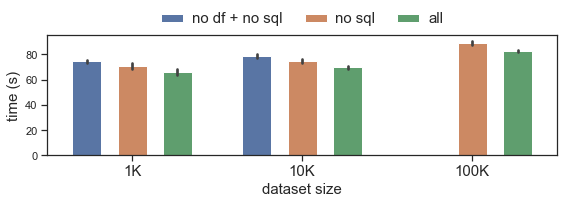

In [7]:
import matplotlib.pyplot as plt
ax = sns.barplot(x="Data size", y="time (s)", hue="Optimisations", data=df, ci="sd")

widthbars = [0.17] * 9

def change_width(ax, widthbars):
    for bar, newwidth in zip(ax.patches, widthbars):
        x = bar.get_x()
        width = bar.get_width()
        centre = x + width/2.
        bar.set_x(centre - newwidth/2.)
        bar.set_width(newwidth)
        
change_width(ax, widthbars)
ax.set_xlabel('dataset size',fontsize = 15)
ax.set_ylabel('time (s)',fontsize = 15)
ax.set_xticklabels(['1K', '10K', '100K'],fontsize = 15);
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='15')

plt.savefig('ablation.pdf')